In [15]:
!export CUDA_VISIBLE_DEVICES=0

import os, torch, pdb

import numpy as np 
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot, init_notebook_mode, iplot
import plotly.express as px

from rdkit.Chem import AllChem

from escnn import gspaces, nn, group


from vae_dist.dataset.fields import mat_pull, split_and_filter
from vae_dist.dataset.dataset import FieldDataset, dataset_split_loader
from vae_dist.core.O3VAE import R3VAE
from vae_dist.core.R3CNN import R3CNN
from vae_dist.core.VAE import baselineVAEAutoencoder
from vae_dist.core.CNN import CNNAutoencoderLightning


init_notebook_mode(connected=True)


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
from vae_dist.core.training import construct_model 
import json 


options = json.load(open('./options/options_escnn_default.json'))
log_save_dir = "./log_version_escnn_1/"
model_escnn = construct_model("escnn", options)

options = json.load(open('./options/options_esvae_default.json'))
log_save_dir = "./log_version_esvae_1/"
model_esvae = construct_model("esvae", options)

options = json.load(open('./options/options_cnn_default.json'))
log_save_dir = "./log_version_auto_1/"
model_cnn = construct_model("auto", options)

options = json.load(open('./options/options_vae_default.json'))
log_save_dir = "./log_version_vae_1/"
model_vae = construct_model("vae", options)


#model.load_model("./log_version_auto_1/autoenc_1.ckpt")

48 100
100 100
100 2


In [18]:
model_esvae.load_model("./log_version_esvae_1/model_1.ckpt")
model_vae.load_model("./log_version_vae_1/model_1.ckpt")
# move model to gpu 
model_esvae.to(device)
model_vae.to(device)

Model Created!
Model Created!


baselineVAEAutoencoder(
  (fc_mu): Linear(in_features=4, out_features=2, bias=True)
  (fc_var): Linear(in_features=4, out_features=2, bias=True)
  (encoder): Sequential(
    (0): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(3, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=78608, out_features=4, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=78608, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(16, 17, 17, 17))
    (3): UpConvBatch(
      (up): Sequential(
        (0): ConvTranspose3d(16, 3, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): LeakyReLU(negative_slope=0.01)
    (5): Sigmoid()
 

In [19]:
model_esvae.load_model("./log_version_esvae_1/model_1.ckpt")
#model_cnn.to(device)
model_esvae.to(device)

Model Created!


R3VAE(
  (fc_mu): Linear(in_features=10, out_features=10, bias=True)
  (fc_var): Linear(in_features=10, out_features=10, bias=True)
  (encoder_fully_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=48, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU()
    (5): Linear(in_features=50, out_features=10, bias=True)
    (6): ReLU()
  )
  (decoder_fully_net): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=48, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(48, 1, 1, 1))
  )
  (decoder): SequentialModule(
    (0): R3ConvTransposed([O(3)_on_R3[o3]: {irrep_0,0 (x48)}(48)], [O(3)_on_R3[o3]: {irrep_0,0 (x240)}(240)], kernel_size=5, stride=1, padding=2, bias=False)
    (1): ReLU(inplace=True, type

In [20]:
root = "../../data/augment_test/"
dataset_test = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )

dataset_loader_full = torch.utils.data.DataLoader(
        dataset_test, 
        batch_size=10,
        shuffle=True,
        num_workers=0
    )

(8, 3, 21, 21, 21)
(8, 21, 21, 21)
(2, 4, 6, 16)
efield_cox_1a4e1_3.dat
0.0 198.443 2.0127446641340705 0.3664801186696901
Largest value in dataset:  98.40626224703891
Smallest value in dataset:  -34.404483044627554


In [21]:
root = "../../data/cpet/"

dataset = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )

(187, 3, 21, 21, 21)
(187, 21, 21, 21)
(117, 20, 14, 18)
efield_cox_5l92.dat
0.0008873698092109061 4370.6400039582795 6.992790413113797 1.1772095293703482
Largest value in dataset:  624.8435957578512
Smallest value in dataset:  -362.13168803281246


# Latent Space Plotting

Total number of fields:  187


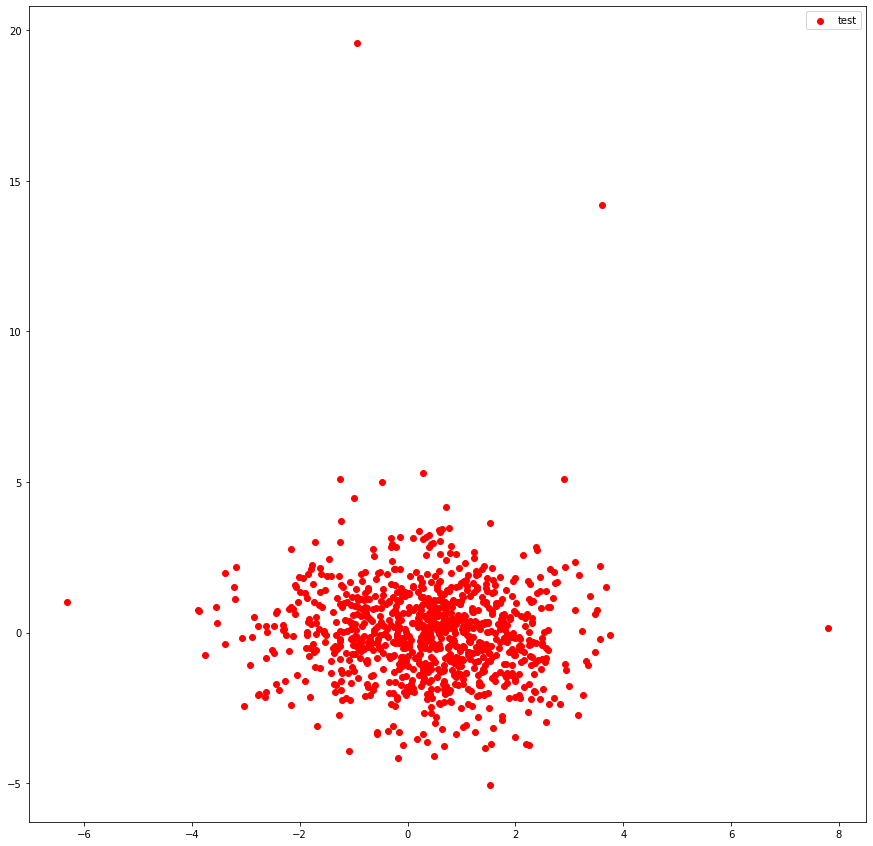

In [22]:

def get_latent_space(model, dataset, comp=[0, 2], latent_dim=10):
    latent_space = []
    # convert load to numpy 
    dataset_loader_np = []
    print("Total number of fields: ", len(dataset))
    for ind in range(len(dataset)):
        field=dataset[ind].reshape(1, 3, 21, 21, 21)
        latent = model.latent(field)
        #print(latent.shape)
        latent_space.append(latent.detach().cpu().numpy())
    return np.array(latent_space).reshape(-1, latent_dim)[:, comp]



plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model_esvae, dataset, comp=[0, 1], latent_dim=2)
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
plt.legend()
plt.show()

In [29]:
# Rotations on latent space

root = "../../data/augment_test/"
dataset_aug = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )


plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model, dataset, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
latent_space = get_latent_space(model, dataset_aug, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="green", label="augment")

plt.legend()
plt.show()



Largest value in dataset:  0.9999994960772131
Smallest value in dataset:  -0.3471241882433806
Total number of fields:  187


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_bmm)

<Figure size 1080x1080 with 0 Axes>

# run the equivariance test


In [11]:


def equiv_test(model, dataset_test, device):
    print('##########################################################################################')
    with torch.no_grad():
        #x = next(iter(dataset_test)).reshape(1, 3, 21, 21, 21).to(device)
        x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
        y = model(x).to('cpu')
        print("Outputs' magnitudes")
        print(torch.linalg.norm(y, dim=1).numpy().reshape(-1))
        # print largest value 
        print("Largest value")
        print(torch.max(torch.linalg.norm(y, dim=1)).numpy())
        print('##########################################################################################')
        print("Errors' magnitudes")
        for r in range(8):
            # sample a random rotation
            g = groupie.sample()
            x_equi = feat_type_in(dataset_test[r].reshape(1, 3, 21, 21, 21).to(device))
            x_transformed = g @ x_equi
            x_transformed = x_transformed.to(device)
            y_transformed = model(x).to('cpu')
            
            y_group_rep = feat_type_in(y)
            # verify that f(g@x) = g@f(x)=g@y
            # print maximum error
            #print(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1).numpy().reshape(-1))        
            print("Largest error")
            print(torch.max(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1)).numpy())
    print('##########################################################################################')
    print()
equiv_test(model, dataset_test, device)

##########################################################################################
Outputs' magnitudes
[3.063006e-05 3.063006e-05 3.063006e-05 ... 3.063006e-05 3.063006e-05
 3.063006e-05]
Largest value
0.75596917
##########################################################################################
Errors' magnitudes
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
##########################################################################################



In [109]:
model_fresh = R3Net(
        0.0005,
        group_space,
        feat_type_in = feat_type_in, 
        feat_type_out = feat_type_out, 
        kernel_size=kernel_size,
        latent_dim=10, 
        fully_connected_dims=[100, 100, 100]
    )
model_fresh = model_fresh.cuda()
equiv_test(model_fresh, dataset_test, device)

48 100
100 100
100 10
##########################################################################################
Outputs' magnitudes
[2.8252327e-05 2.8252327e-05 2.8252327e-05 ... 2.8252327e-05 2.8252327e-05
 2.8252327e-05]
Largest value
0.26404372
##########################################################################################
Errors' magnitudes
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
##########################################################################################



In [19]:
dataset.names

['efield_cox_1hch.dat',
 'efield_cox_3abb.dat',
 'efield_cox_5it1.dat',
 'efield_cox_1lga.dat',
 'efield_cox_6fiy.dat',
 'efield_cox_4au9.dat',
 'efield_cox_4nos.dat',
 'efield_cox_6wk3.dat',
 'efield_cox_4nz2.dat',
 'efield_cox_4tt5.dat',
 'efield_cox_1mqf.dat',
 'efield_cox_6j95.dat',
 'efield_cox_5sx0.dat',
 'efield_cox_5hwz.dat',
 'efield_cox_3t3z.dat',
 'efield_cox_2e39.dat',
 'efield_cox_1dgh.dat',
 'efield_cox_1v8x.dat',
 'efield_cox_3re8.dat',
 'efield_cox_2wm4.dat',
 'efield_cox_4ict.dat',
 'efield_cox_5aog.dat',
 'efield_cox_1si8.dat',
 'efield_cox_3mvr.dat',
 'efield_cox_3lgm.dat',
 'efield_cox_1a4e.dat',
 'efield_cox_1ulw.dat',
 'efield_cox_3bk9.dat',
 'efield_cox_3hdl.dat',
 'efield_cox_5hdi.dat',
 'efield_cox_6h1l.dat',
 'efield_cox_2zqx.dat',
 'efield_cox_1u5u.dat',
 'efield_cox_2xkr.dat',
 'efield_cox_4gs1.dat',
 'efield_cox_5edt.dat',
 'efield_cox_5o1l.dat',
 'efield_cox_4a5g.dat',
 'efield_cox_3atj.dat',
 'efield_cox_4ubs.dat',
 'efield_cox_4d6z.dat',
 'efield_cox_1ji

# Visualize in/out field from model


In [23]:

def plot_vfield(mat, cutoff_low = 95, cutoff_high = 99.999, min_max = True, scale = 10):
        x = mat #dataset_test.data[0] 
        x = x.reshape(21, 21, 21, 3)
        u_1, v_1, w_1 = split_and_filter(x, min_max = min_max, cutoff_low = cutoff_low, cutoff_high = cutoff_high)  
        a, b, c = np.meshgrid(
                np.arange(-3, 3.3, 0.3),
                np.arange(-3, 3.3, 0.3),
                np.arange(-3, 3.3, 0.3)
                )

        #max value of each dimension
        max_u = np.max(u_1)
        max_v = np.max(v_1)
        max_w = np.max(w_1)
        print(max_u, max_v, max_w)
        
        cones = go.Cone(
                x=a.flatten(), 
                y=b.flatten(), 
                z=c.flatten(), 
                u=u_1 ,
                v=v_1 , 
                w=w_1 ,
                sizeref=scale,)
                #opacity=0.0) 
                
        layout = go.Layout(
                title='Cones',
                width=700,
                height=700,
                        #sizeref=0.5,
                        #anchor='tail'
                )

        fig = go.Figure(data=cones,layout=layout)
        iplot(fig)


plot_vfield(
        dataset.data[0], 
        cutoff_low = 70, 
        cutoff_high=99.999, 
        min_max = False,
        scale = 2)
#fig.show()
#fig.write_html("cones_.html")

2.65 3.39 2.41


In [27]:
# model reconstruction

x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
x_out = model_esvae.forward(x)
x_out = x_out.to('cpu').detach().numpy().reshape(3, 21, 21, 21)

plot_vfield(
        x_out, 
        cutoff_low = 0, 
        cutoff_high=100, 
        min_max = False,
        scale = 2)


0.0 0.0 0.0


# Q-Q Plot

Total number of fields:  187


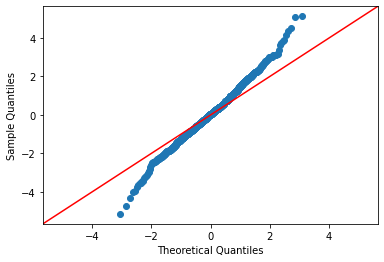

In [35]:
# q-q plot of the latent space

latent_space = get_latent_space(model_esvae, dataset, comp=[0, 1], latent_dim=2)

import scipy.stats as stats
import pylab 
import statsmodels.api as sm
sm.qqplot(latent_space[:,1], line='45')
pylab.show()



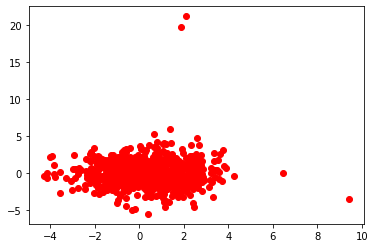

In [29]:
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
